In [1]:
from IPython.display import Image

import pickle as pkl
import scipy.sparse as sp
from scipy.sparse.linalg.eigen.arpack import eigsh
import sys

import random
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import tensorflow as tf

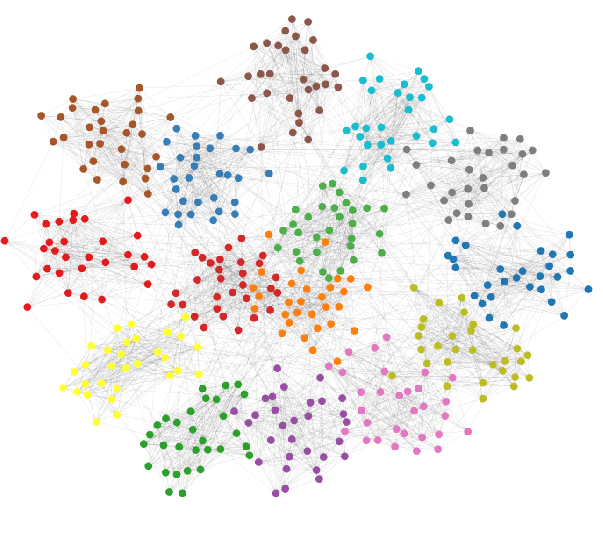

In [2]:
Image(filename='D:/bigdata/Python/pictures/gnn.png')

# Karate Datasets

C:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


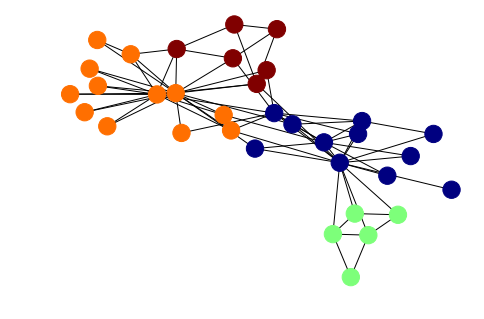

In [3]:
g = nx.read_graphml('D:/bigdata/Python/Graph Neural Net/R/karate.graphml')

plt.figure()
nx.draw(g, cmap=plt.get_cmap('jet'),
    node_color=np.log(list(nx.get_node_attributes(g, 'membership').values())))
plt.show()

In [4]:
# Get important parameters of adjacency matrix
adj = nx.adj_matrix(g)


In [5]:
n_nodes = adj.shape[0]


## Some preprocessing

In [6]:
adj_tilde = adj + np.identity(n=adj.shape[0], dtype=np.float32)
print(adj_tilde)
numpy_adj=adj_tilde-np.identity(n=adj.shape[0], dtype=np.float32)

[[1. 1. 1. ... 1. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 1. 0.]
 ...
 [1. 0. 0. ... 1. 1. 1.]
 [0. 0. 1. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]]


In [7]:
print(numpy_adj.shape)

(34, 34)


In [8]:
d_tilde_diag = np.squeeze(np.sum(np.array(adj_tilde), axis=1))
print(d_tilde_diag)

[17. 10. 11.  7.  4.  5.  5.  5.  6.  3.  4.  2.  3.  6.  3.  3.  3.  3.
  3.  4.  3.  3.  3.  6.  4.  4.  3.  5.  4.  5.  5.  7. 13. 18.]


In [9]:
d_tilde_inv_sqrt_diag = np.power(d_tilde_diag, -1/2, dtype=np.float32)
print(d_tilde_inv_sqrt_diag)

[0.24253562 0.31622776 0.30151135 0.37796447 0.5        0.4472136
 0.4472136  0.4472136  0.4082483  0.57735026 0.5        0.70710677
 0.57735026 0.4082483  0.57735026 0.57735026 0.57735026 0.57735026
 0.57735026 0.5        0.57735026 0.57735026 0.57735026 0.4082483
 0.5        0.5        0.57735026 0.4472136  0.5        0.4472136
 0.4472136  0.37796447 0.2773501  0.23570226]


In [10]:
d_tilde_inv_sqrt = np.diag(d_tilde_inv_sqrt_diag)
print(d_tilde_inv_sqrt)

[[0.24253562 0.         0.         ... 0.         0.         0.        ]
 [0.         0.31622776 0.         ... 0.         0.         0.        ]
 [0.         0.         0.30151135 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.37796447 0.         0.        ]
 [0.         0.         0.         ... 0.         0.2773501  0.        ]
 [0.         0.         0.         ... 0.         0.         0.23570226]]


In [11]:
adj_norm = np.dot(np.dot(d_tilde_inv_sqrt, adj_tilde), d_tilde_inv_sqrt)
adj_norm=adj_norm.astype(np.float32)
print(adj_norm)

[[0.05882353 0.0766965  0.07312724 ... 0.09166985 0.         0.        ]
 [0.0766965  0.1        0.09534626 ... 0.         0.         0.        ]
 [0.07312724 0.09534626 0.09090909 ... 0.         0.0836242  0.        ]
 ...
 [0.09166985 0.         0.         ... 0.14285713 0.10482848 0.08908708]
 [0.         0.         0.0836242  ... 0.10482848 0.07692308 0.06537204]
 [0.         0.         0.         ... 0.08908708 0.06537204 0.05555556]]


### Features are just the identity matrix

In [12]:
feat_x = np.identity(n=adj.shape[0])
print(feat_x.shape[-1])

34


In [13]:
# Semi-supervised
memberships = [m - 1 for m in nx.get_node_attributes(g, 'membership').values()]

nb_classes = len(set(memberships))
targets = np.array([memberships], dtype=np.int32).reshape(-1)
one_hot_targets = np.eye(4)[targets]

# Pick 3 from each class
labels_to_keep=[17,2,3,  4,6,5,  15,9,20,  27,24,31]

y_train = np.zeros(shape=one_hot_targets.shape,
                   dtype=np.float32)
y_test = one_hot_targets.copy()

train_mask = np.zeros(shape=(n_nodes,), dtype=np.bool)
test_mask = np.ones(shape=(n_nodes,), dtype=np.bool)

for l in labels_to_keep:
    y_train[l, :] = one_hot_targets[l, :]
    y_test[l, :] = np.zeros(shape=(nb_classes,))
    train_mask[l] = True
    test_mask[l] = False

# GCN

The equation of graph convolution is as below. <br>
$$ H^{l+1} = \sigma(AH^{l}W^{l}) $$
We will implement this equation in function named graph_conv. The function will receive l-th node features,  adjacency matrix, and the output dimension of node features as inputs. 

Actually, original equation is introduced as above, which does not use bias term, in T.Kipf's paper. However, I think using bias is necessary, as below, because the bias term shifts the decision boundary. 
$$ H^{l+1} = \sigma(A(H^{l}W^{l}+b^{l})) $$
Therefore, I set 'use_bias=True' at a dense layer in the graph convolution.

### H(1)은 Input X = Features Matrix of Graph Node

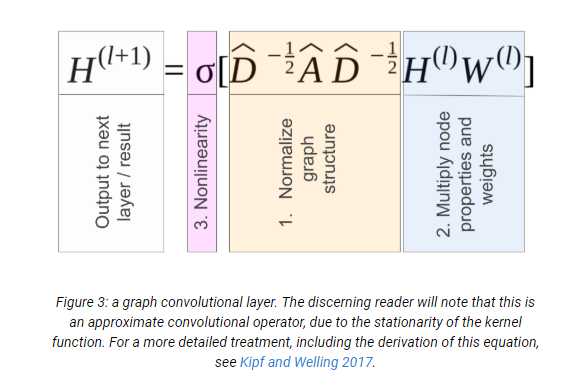

In [19]:
Image(filename='D:/bigdata/Python/pictures/GCN.png')

In [20]:
class GCN:
    def __init__(self, layer, n_nodes, f_dimension, nb_classes):
        self.X = tf.placeholder('float32',shape=(n_nodes, f_dimension))
        self.y = tf.placeholder('float32', shape=(n_nodes, nb_classes))
        self.mask=tf.placeholder('float32')
        self.output_dim = nb_classes
        self.layer = layer
        self.is_train=tf.placeholder(tf.bool)
        self.adj=tf.placeholder('float32',shape=(n_nodes, n_nodes))
        self.dropout=tf.placeholder(tf.float32)
    def loss(self, lr,  optim=tf.train.AdamOptimizer):
        self.L=tf.identity(self.X)
        for j in range(len(self.layer)):
            self.L=tf.contrib.layers.fully_connected(tf.matmul(self.adj,self.L), num_outputs=self.layer[j],
                                             activation_fn=tf.nn.tanh, weights_initializer=tf.contrib.layers.xavier_initializer())
            self.L= tf.nn.dropout(self.L, self.dropout)
            
        self.hypothesis=tf.contrib.layers.fully_connected(tf.matmul(self.adj,self.L), num_outputs=self.output_dim,
                                             activation_fn=tf.nn.softmax, weights_initializer=tf.contrib.layers.xavier_initializer())

        self.cost=tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.y, logits=self.hypothesis)
        mask = tf.cast(self.mask, dtype=tf.float32)
        mask /= tf.reduce_mean(mask)
        
        self.cost *= mask       
        self.cost=tf.reduce_mean(self.cost)
        
        self.optimizer = optim(learning_rate=lr)
        self.trains = self.optimizer.minimize(self.cost)
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    

    def accuracy(self, X, Y, mask, adj):
        """Accuracy with masking."""
        preds, graph_node=self.sess.run([self.hypothesis, self.L], feed_dict={self.X:X, self.y:Y, self.adj:adj,
                                                                              self.mask:mask, self.dropout:1})
        correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(Y, 1))
        accuracy_all = tf.cast(correct_prediction, tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        mask /= tf.reduce_mean(mask)
        accuracy_all *= mask
        return self.sess.run(tf.reduce_mean(accuracy_all)), graph_node
    
        
    
    def train(self, batch_xs, batch_ys, mask, avg_cost, adj):
        _, c = self.sess.run([self.trains, self.cost], feed_dict={self.X: batch_xs, self.y: batch_ys,  self.adj:adj,
                                                                  self.mask:mask, self.dropout:0.9})
        avg_cost += np.mean(c)
        return avg_cost
    
    def draw(self, g, outputs):
        node_positions = {o: {n: tuple(outputs[o][j])
                              for j, n in enumerate(nx.nodes(g))}
                          for o in outputs}
        plot_titles = {o: 'epoch {o}'.format(o=o) for o in outputs}

        # Two subplots, unpack the axes array immediately
        f, axes = plt.subplots(nrows=2, ncols=3, sharey=True, sharex=True)

        e = list(node_positions.keys())

        for i, ax in enumerate(axes.flat):
            pos = node_positions[e[i]]
            ax.set_title(plot_titles[e[i]])

            nx.draw(
                g,
                cmap=plt.get_cmap('jet'),
                node_color=np.log(
                    list(nx.get_node_attributes(g, 'membership').values())),
                pos=pos, ax=ax)

In [21]:
tf.reset_default_graph()
model=GCN([2], 34, 34, 4)

In [22]:
model.loss(1e-2)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.cast instead.


Epoch: 0001 cost= 1.28048 train_acc:  0.5   test_acc:  0.5
Epoch: 0002 cost= 1.11848 train_acc:  0.75   test_acc:  0.5454545
Epoch: 0003 cost= 1.01785 train_acc:  1.0   test_acc:  0.9090908
Epoch: 0004 cost= 0.89815 train_acc:  1.0   test_acc:  0.95454544
Epoch: 0005 cost= 0.87783 train_acc:  1.0   test_acc:  0.95454544
Epoch: 0006 cost= 

C:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


0.83445 train_acc:  1.0   test_acc:  0.95454544


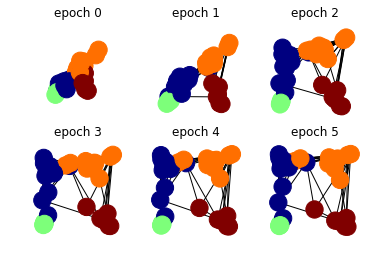

In [23]:
outputs={}
test_outputs={}
for epoch in range(6):
    avg_cost=0
    for i in range(50):
        batch_xs, batch_ys, adj = feat_x,  y_train, np.array(adj_norm)
        avg_cost=model.train(batch_xs, batch_ys, train_mask, avg_cost/50, adj)
    train_acc, outputs[epoch]=model.accuracy(batch_xs, batch_ys, train_mask, adj)
    test_acc, _=model.accuracy(batch_xs, y_test, test_mask, adj)
    print('Epoch:','%04d' %(epoch+1),'cost=', np.round(avg_cost,5),'train_acc: ',train_acc, '  test_acc: ',test_acc)
model.draw(g,outputs)

# Graph attention network(GAT)

Attention mechanism revisits us. <br>
In natural language processing, the attention mechanisms - local and global - find the relationship between the words and give scores. 

We can apply the attention in graph convolution network as well. <br>
A node embedding in GCN is 

$$ H_i^{(l)} = \sigma( \sum_{j \in N(i)} H_j^{(l)}W^{(l)} )$$

GCN considers the adjacent nodes and itself with equal weights in updating node states.<br>
However, it is more natural that the importance of each node is different, and the importance can be obtained by learning the relationship between node states.

With attention coefficient, the node embedding can be rewritten as follow.

$$ H_i^{(l+1)} = \sigma( \sum_{j \in N(i)} \alpha_{ij}^{(l)} H_j^{(l)}W^{(l)} ) $$
$$ \alpha_{ij}^{(l)} = f(H_i^{(l)}W^{(l)}, H_j^{(l)}W^{(l)}) $$

There are various approaches to obtain the attention coefficient, $\alpha_{ij}$, and three approaches are introduced in the following reference: 
* Luong, Minh-Thang, Hieu Pham, and Christopher D. Manning. "Effective approaches to attention-based neural machine translation." arXiv preprint arXiv:1508.04025 (2015).

In the paper "Graph attention networks", authors represent the attention coefficient by concatenation. 
* Velickovic, Petar, et al. "Graph attention networks." arXiv preprint arXiv:1710.10903 (2017).

$$ \alpha_{ij} = softmax(e_{ij}) = \frac{e_{ij}}{\sum_{k \in N(i)} e_{ik}} $$
$$ e_{ij} = f(H_iW, H_jW) = \tau(a^T (H_iW||H_jW))$$

Normalizing the coefficient with softmax activation isn't proper for molecular applications, however, we recommend $e_{ij}$ term only for the case. <br>
We use a general form of the attention in our works which investigate molecular structure property relationship using the graph attention network.
* Ryu, Seongok, Jaechang Lim, and Woo Youn Kim. "Deeply learning molecular structure-property relationships using graph attention neural network." arXiv preprint arXiv:1805.10988 (2018).

$$ \alpha_{ij} = \sigma((H_iW)C(H_jW)^T) $$

The concatenation method needs $2F$ number of paramters need to be trained, however, our one needs $F^2$.
If F is larger than 2, the former one is more efficient. The feature dimensions in our applications are not large, however, it was okay to use later one. 

In addition, we can use multiple times of the attention mechanism in single node updating - so called multi-head attention. <br>
Two ways are introduced in the original GAT paper, one represents by average of all attention channels.

$$ H_i^{(l)} = \sigma( \frac{1}{K} \sum_{k=1}^{K} \sum_{j \in N(i)} \alpha_{ij,k}^{(l)}H_j^{(l)}W_k^{(l)} ) $$

and the other by concatenation of channels.

$$ H_i^{(l)} = ||_{k=1}^K \sigma( \sum_{j \in N(i)} \alpha_{ij,k}^{(l)}H_j^{(l)}W_k^{(l)} ) $$

In summary, schematic desription is shown in below figure.

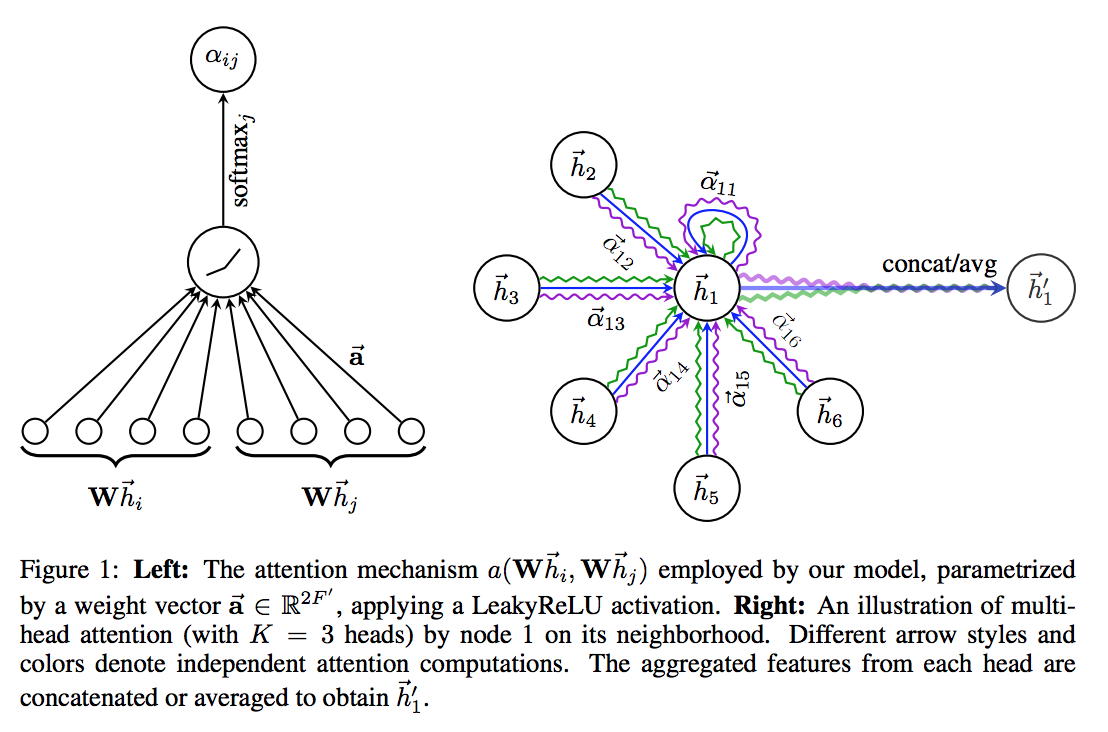

In [24]:
Image(filename='D:/bigdata/Python/pictures/graaph attention networks.png')

##### Image source : Velickovic, Petar, et al. "Graph attention networks." arXiv preprint arXiv:1710.10903 (2017).

Let's implement the graph attention network.

In [27]:
class GAT_original:
    def __init__(self, layer, n_nodes, f_dimension, nb_classes):
        self.X = tf.placeholder('float32',shape=(None, n_nodes, f_dimension), name='x')
        self.y = tf.placeholder('float32', shape=(None, n_nodes, nb_classes), name='y')
        self.adj=tf.placeholder('float32',shape=(None, n_nodes, n_nodes), name='adj')
        self.mask=tf.placeholder('float32',shape=(None, n_nodes), name='x_mask')
        self.output_dim = nb_classes
        self.layer = layer
        self.is_train=tf.placeholder(tf.bool)
        self.nodes=n_nodes
        self.dropout=tf.placeholder(tf.float32)
    def loss(self,  lr, optim=tf.train.AdamOptimizer):
        # K-head attention
#         self.hidden_layer=tf.identity(self.X)
#         for i, hidden_layer in enumerate(self.layer):
#             self.hidden_layer = tf.layers.dense(self.hidden_layer, hidden_layer)
#             self.coeffs = self.attn_coeffs(self.hidden_layer, self.adj)
#             self.hidden_layer = tf.matmul(self.coeffs, self.hidden_layer) # [batch_size, num_nodes, num_nodes]  
#             self.hidden_layer = tf.nn.dropout( self.hidden_layer, self.dropout)


#         self.hidden_layer=tf.identity(self.X)
#         self.hidden_layer = tf.layers.dense(self.hidden_layer, self.layer[0])
#         self.coeffs = self.attn_coeffs(self.hidden_layer, self.adj)
#         self.hidden_layer = tf.matmul(self.coeffs, self.hidden_layer) # [batch_size, num_nodes, num_nodes]  
#         self.hidden_layer = tf.nn.dropout(self.hidden_layer, self.dropout)
#         for i, hidden_layer in enumerate(self.layer[1:]):
#             self.hidden_layer = tf.layers.dense(self.hidden_layer, hidden_layer)
#             self.hidden_layer = tf.matmul(self.coeffs, self.hidden_layer)
#             self.hidden_layer = tf.nn.dropout(self.hidden_layer, self.dropout)
            
    
    
        self.hidden_layer=tf.identity(self.X)
        self.coeffs = self.attn_coeffs(self.hidden_layer, self.adj)
        for i, hidden_layer in enumerate(self.layer):
            self.hidden_layer = tf.layers.dense(self.hidden_layer, hidden_layer)
            self.hidden_layer = tf.matmul(self.coeffs, self.hidden_layer)
            self.hidden_layer = tf.nn.dropout(self.hidden_layer, self.dropout)
            
            
            
    
    
        self.hypothesis = tf.layers.dense(tf.matmul(self.adj, self.hidden_layer), self.output_dim, activation=tf.nn.softmax)

        self.cost=tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.y, logits=self.hypothesis)
        mask = tf.cast(self.mask, dtype=tf.float32)
        mask /= tf.reduce_mean(mask)
        
        self.cost *= mask       
        self.cost=tf.reduce_mean(self.cost)
        
        self.optimizer = optim(learning_rate=lr)
        self.trains = self.optimizer.minimize(self.cost)
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    
    def attn_coeffs(self, H, A, active=tf.nn.tanh):
        B, N, D= H.get_shape().as_list()
        a_input = tf.reshape(tf.concat([tf.reshape(tf.tile(H,(1,1, N)),(1,N*N,-1)), tf.tile(H,(1,N,1))], axis=1),(-1,N, N, 2 * D))
        e = tf.nn.leaky_relu(tf.reshape(tf.matmul(tf.reshape(a_input,[-1,D*2]),tf.zeros(shape=(D*2, 1))),[-1,N,N]))
        zero_vec = -9e15*tf.ones_like(e)
        attention = tf.where(A > 0, e, zero_vec)
        attention = tf.nn.softmax(attention, dim=1)
        return attention
    
    
    
    def accuracy(self, X, Y, mask, adj):
        """Accuracy with masking."""
        preds, graph_node=self.sess.run([self.hypothesis, self.hidden_layer], feed_dict={self.X:X, self.y:Y,  self.adj:adj,
                                                                              self.mask:mask, self.dropout:1})
        correct_prediction = tf.equal(tf.argmax(preds, 2), tf.argmax(Y, 2))
        accuracy_all = tf.cast(correct_prediction, tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        mask /= tf.reduce_mean(mask)
        accuracy_all *= mask
        return preds[0], self.sess.run(tf.reduce_mean(accuracy_all)), graph_node[0]
    
        
    def get_attn(self, x, adj):
        return self.sess.run(self.coeffs, feed_dict={self.X:x, self.adj:adj})[0]
    
    def train(self, batch_xs, batch_ys, mask, avg_cost, adj):
        _, c = self.sess.run([self.trains, self.cost], feed_dict={self.X: batch_xs, self.y: batch_ys, self.adj:adj,
                                                                  self.mask:mask, self.dropout:0.90})
        avg_cost += np.mean(c)
        return avg_cost
    
    def draw(self, g, outputs):
        node_positions = {o: {n: tuple(outputs[o][j])
                              for j, n in enumerate(nx.nodes(g))}
                          for o in outputs}
        plot_titles = {o: 'epoch {o}'.format(o=o) for o in outputs}

        # Two subplots, unpack the axes array immediately
        f, axes = plt.subplots(nrows=2, ncols=3, sharey=True, sharex=True)

        e = list(node_positions.keys())

        for i, ax in enumerate(axes.flat):
            pos = node_positions[e[i]]
            ax.set_title(plot_titles[e[i]])

            nx.draw(
                g,
                cmap=plt.get_cmap('jet'),
                node_color=np.log(
                    list(nx.get_node_attributes(g, 'membership').values())),
                pos=pos, ax=ax)

In [31]:
tf.reset_default_graph()
model=GAT_original([2], 34, 34, 4)

In [32]:
model.loss(1e-2)

Epoch: 0001 cost= 1.2606 train_acc:  0.5   test_acc:  0.22727272
Epoch: 0002 cost= 1.08134 train_acc:  0.75   test_acc:  0.6363636
Epoch: 0003 cost= 0.9049 train_acc:  1.0   test_acc:  1.0
Epoch: 0004 cost= 0.80304 train_acc:  1.0   test_acc:  1.0
Epoch: 0005 cost= 0.83697 train_acc:  1.0   test_acc:  1.0
Epoch: 0006 cost= 0.77374 train_acc:  1.0   test_acc:  1.0


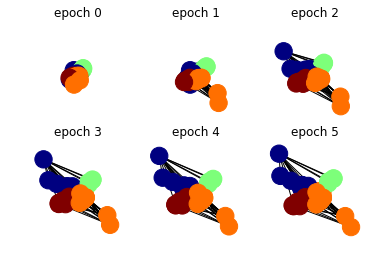

In [33]:
outputs={}
test_outputs={}
for epoch in range(6):
    avg_cost=0
    for i in range(50):
        batch_xs, batch_ys, adj=feat_x.reshape((1,34,34)),  y_train.reshape((1,34,4)), np.array(adj_norm).reshape((1,34,34))
        avg_cost=model.train(batch_xs, batch_ys, train_mask.reshape((1,34)), avg_cost/50, adj)
    preds, train_acc, outputs[epoch]=model.accuracy(batch_xs, batch_ys, train_mask.reshape((1,34)), adj)
    preds, test_acc, _=model.accuracy(batch_xs, y_test.reshape((1,34,4)), test_mask.reshape((1,34)), adj)
    print('Epoch:','%04d' %(epoch+1),'cost=', np.round(avg_cost,5),'train_acc: ',train_acc, '  test_acc: ',test_acc)

model.draw(g,outputs)
    


In [34]:
model.get_attn(batch_xs, adj)[0]

array([0.05882353, 0.1       , 0.09090909, 0.14285715, 0.25      ,
       0.2       , 0.2       , 0.2       , 0.16666667, 0.        ,
       0.25      , 0.5       , 0.33333334, 0.16666667, 0.        ,
       0.        , 0.        , 0.33333334, 0.        , 0.25      ,
       0.        , 0.33333334, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.14285715, 0.        , 0.        ], dtype=float32)

In [20]:
model.get_attn(batch_xs, adj)[0]

array([0.05882353, 0.1       , 0.09090909, 0.14285715, 0.25      ,
       0.2       , 0.2       , 0.2       , 0.16666667, 0.        ,
       0.25      , 0.5       , 0.33333334, 0.16666667, 0.        ,
       0.        , 0.        , 0.33333334, 0.        , 0.25      ,
       0.        , 0.33333334, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.14285715, 0.        , 0.        ], dtype=float32)

In [41]:
class GAT_Ryu:
    def __init__(self, layer, n_nodes, f_dimension, nb_classes):
        self.X = tf.placeholder('float32',shape=(None, n_nodes, f_dimension), name='x')
        self.y = tf.placeholder('float32', shape=(None, n_nodes, nb_classes), name='y')
        self.adj=tf.placeholder('float32',shape=(None, n_nodes, n_nodes))
        self.mask=tf.placeholder('float32',shape=(None, n_nodes), name='x')
        
        self.output_dim = nb_classes
        self.layer = layer
        self.is_train=tf.placeholder(tf.bool)
        self.nodes=n_nodes
        self.dropout=tf.placeholder(tf.float32)
    def loss(self,  lr,   optim=tf.train.AdamOptimizer):
        # K-head attention
        self.hidden_layer=tf.identity(self.X)
        for i,hidden_layer in enumerate(self.layer):
            C_i = tf.get_variable('attn_weight-'+str(i), initializer=tf.contrib.layers.xavier_initializer(), shape=[hidden_layer, hidden_layer], dtype=tf.float32)
            self.hidden_layer = tf.layers.dense(self.hidden_layer, hidden_layer)
            attn_matrix = self.attn_coeffs(self.hidden_layer, self.adj, C_i)
            self.hidden_layer = tf.matmul(attn_matrix, self.hidden_layer)
            self.hidden_layer= tf.nn.relu(self.hidden_layer)
            self.hidden_layer = tf.nn.dropout(self.hidden_layer, self.dropout)
        self.hypothesis = tf.layers.dense(tf.matmul(self.adj, self.hidden_layer), self.output_dim, activation=tf.nn.softmax)

        self.cost=tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.y, logits=self.hypothesis)
        mask = tf.cast(self.mask, dtype=tf.float32)
        mask /= tf.reduce_mean(mask)
        
        self.cost *= mask       
        self.cost=tf.reduce_mean(self.cost)
        
        self.optimizer = optim(learning_rate=lr)
        self.trains = self.optimizer.minimize(self.cost)
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    def attn_coeffs(self, _X, _A, _C, active=tf.nn.tanh):
        # _X : [batch_size, num_nodes, num_features]
        # _A : [batch_size, num_nodes, num_nodes]
        # C : [num_features, num_features]
        # A : [batch_size, num_nodes, num_nodes]
        # A = activation(_X * C * _X^T)
        X1 = tf.transpose(_X, [0,2,1])   # [batch_size, num_features, num_nodes]  HW.T(HjW)
        X2 = tf.einsum('ij,ajk->aik', _C, X1)  # [batch_size, num_features, num_nodes] C(HjW)
        attn_matrix = tf.matmul(_X, X2) # [batch_size, num_nodes, num_nodes]    (HiW)C(HjW)
        attn_matrix = tf.multiply(_A, attn_matrix) # [batch_size, num_nodes, num_nodes]  
        attn_matrix = active(attn_matrix)
        return attn_matrix

    def accuracy(self, X, Y, mask, adj):
        """Accuracy with masking."""
        preds, graph_node=self.sess.run([self.hypothesis, self.hidden_layer], feed_dict={self.X:X, self.y:Y,  self.adj:adj,
                                                                              self.mask:mask, self.dropout:1})
        correct_prediction = tf.equal(tf.argmax(preds, 2), tf.argmax(Y, 2))
        accuracy_all = tf.cast(correct_prediction, tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        mask /= tf.reduce_mean(mask)
        accuracy_all *= mask
        return preds[0], self.sess.run(tf.reduce_mean(accuracy_all)), graph_node[0]
    
        
    
    def train(self, batch_xs, batch_ys, mask, avg_cost, adj):
        _, c = self.sess.run([self.trains, self.cost], feed_dict={self.X: batch_xs, self.y: batch_ys, self.adj:adj,
                                                                  self.mask:mask, self.dropout:0.9})
        avg_cost += np.mean(c)
        return avg_cost
    
    def draw(self, g, outputs):
        node_positions = {o: {n: tuple(outputs[o][j])
                              for j, n in enumerate(nx.nodes(g))}
                          for o in outputs}
        plot_titles = {o: 'epoch {o}'.format(o=o) for o in outputs}

        # Two subplots, unpack the axes array immediately
        f, axes = plt.subplots(nrows=2, ncols=3, sharey=True, sharex=True)

        e = list(node_positions.keys())

        for i, ax in enumerate(axes.flat):
            pos = node_positions[e[i]]
            ax.set_title(plot_titles[e[i]])

            nx.draw(
                g,
                cmap=plt.get_cmap('jet'),
                node_color=np.log(
                    list(nx.get_node_attributes(g, 'membership').values())),
                pos=pos, ax=ax)

In [42]:
def attn_coeffs(_X, _A, _C, active=tf.nn.tanh):
    # _X : [batch_size, num_nodes, num_features]
    # _A : [batch_size, num_nodes, num_nodes]
    # C : [num_features, num_features]
    # A : [batch_size, num_nodes, num_nodes]
    # A = activation(_X * C * _X^T)
    X1 = tf.transpose(_X, [0,2,1])   # [batch_size, num_features, num_nodes]  HW.T(HjW)
    X2 = tf.einsum('ij,ajk->aik', _C, X1)  # [batch_size, num_features, num_nodes] C(HjW)
    attn_matrix = tf.matmul(_X, X2) # [batch_size, num_nodes, num_nodes]    (HiW)C(HjW)
    attn_matrix = tf.multiply(_A, attn_matrix) # [batch_size, num_nodes, num_nodes]
    attn_matrix = active(attn_matrix)
    return attn_matrix

In [43]:
def graph_attn(_X, _A, output_dim, num_channels):

    # K-head attention
    states = []
    for k in range(num_channels):
        C_k = tf.get_variable('attn_weight-'+str(k), initializer=tf.contrib.layers.xavier_initializer(), shape=[output_dim, output_dim], dtype=tf.float64)
        X_k = tf.layers.dense(_X, output_dim, use_bias=True)
        attn_matrix = attn_coeffs(X_k, _A, C_k)
        X_k = tf.matmul(attn_matrix, X_k)
        states.append(X_k)
    
    output = tf.reduce_mean(states, 0)
    output = tf.nn.relu(output)
    
    return output

In [44]:
tf.reset_default_graph()
model=GAT_Ryu([2], 34, 34, 4)

In [45]:
model.loss(1e-2)

Epoch: 0001 cost= 1.2909 train_acc:  0.5   test_acc:  0.5
Epoch: 0002 cost= 1.03525 train_acc:  0.8333333   test_acc:  0.7272727
Epoch: 0003 cost= 0.93492 train_acc:  1.0   test_acc:  0.7727272
Epoch: 0004 cost= 0.87456 train_acc:  1.0   test_acc:  0.7272727
Epoch: 0005 cost= 0.80062 train_acc:  1.0   test_acc:  0.7272727
Epoch: 0006 cost= 0.86247 train_acc:  1.0   test_acc:  0.7272727


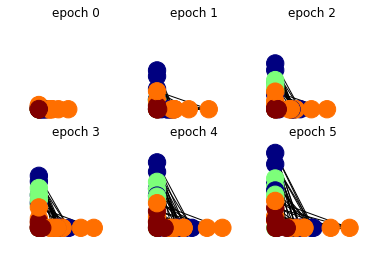

In [46]:
outputs={}
test_outputs={}
for epoch in range(6):
    avg_cost=0
    for i in range(50):
        batch_xs, batch_ys, adj=feat_x.reshape((1,34,34)),  y_train.reshape((1,34,4)), np.array(adj_norm).reshape((1,34,34))
        avg_cost=model.train(batch_xs, batch_ys, train_mask.reshape((1,34)), avg_cost/50, adj)
    preds, train_acc, outputs[epoch]=model.accuracy(batch_xs, batch_ys, train_mask.reshape((1,34)), adj)
    preds, test_acc, _=model.accuracy(batch_xs, y_test.reshape((1,34,4)), test_mask.reshape((1,34)), adj)
    print('Epoch:','%04d' %(epoch+1),'cost=', np.round(avg_cost,5),'train_acc: ',train_acc, '  test_acc: ',test_acc)

model.draw(g,outputs)
    


In [56]:
np.argmax(preds,1)

array([2, 0, 0, 0, 1, 1, 1, 0, 2, 2, 1, 1, 0, 2, 2, 2, 1, 0, 2, 2, 2, 0,
       2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2], dtype=int64)

In [57]:
targets

array([0, 0, 0, 0, 1, 1, 1, 0, 2, 2, 1, 0, 0, 0, 2, 2, 1, 0, 2, 0, 2, 0,
       2, 3, 3, 3, 2, 3, 3, 2, 2, 3, 2, 2])

# Gated Graph Neural Network(GGNN)

We have found that GCN and GAT are CNN-like versions of graph neural networks. GGNN, on the other hand, is the RNN-like version of the node updating method. 

First, let's look at the message passing neural network (MPNN) framework. The MPNN framework updates the route node with the following formula. <br>

$$ H_{i}^{(l+1)} = U(H_{i}^{(l)}, m^{(l+1)}) $$

The i-th node, which is a route node, is newly updated through the message state, $m^{(i+1)}$ from the neighboring nodes and previous node state, $H^{(l)}$. <br>

Updating message state can be written as a general formulation as follow.

$$ m^{(l+1)} = \sum_{j \in N_{i}} M(H_i^{(l)}, H_j^{(l)}, e_{ij}) $$

If we know the initial edge information - $e_{ij}$, we can update the message states differently for different relations, for example a single bond, a double bond and an aromatic bond will transfer a different message to the route node. <br>
For simpliticy, we will only consider just connectivity between the node pairs, i.e.) $A_{ij} =1$ for connected node pairs, and zero otherwise.

In GGNN framework, message function is defined as simple summation of the neighbor node states.

$$ m^{(l+1)} = \sum_{j \in N_{i}} H_j^{(l)} $$

And the gated recurrent unit (GRU) is used for the node updating. Finally, the node updating is re-written as follow.

$$ H_i^{(l+1)} = GRU(H_i^{(l)}, \sum_{j \in N_i} H_i^{(l)}) $$

We will implement the updating function in the GGNN framework.

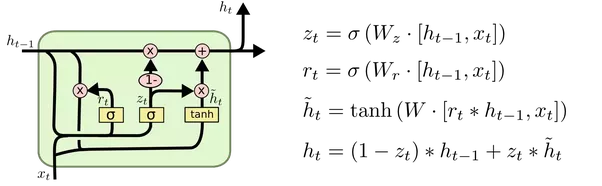

In [47]:
Image(filename='D:/bigdata/Python/pictures/gru.png')

In [ ]:
def ggnn(_X, _A, output_dim, num_layer):
    # Message state
    m = tf.matmul(_A, _X)
    
    # Update node state using GRU cell
    X_total = []
    cell = tf.contrib.rnn.GRUCell(output_dim, name='GRUcell'+str(num_layer))
    
    for i in range(num_nodes):
        mi = tf.reshape(m[:,i,:],(-1,1,output_dim))
        print(mi.shape)
        hi = _X[:,i,:]
        _, _h = tf.nn.dynamic_rnn(cell, mi, initial_state=hi)
        X_total.append(tf.reshape(_h,(-1,1,output_dim)))
    output = tf.concat(X_total, 1)
    return output

In [48]:
def ggnn(_X, _A, output_dim, num_layer):
    num_nodes = int(_X.get_shape()[1])
    input_dim = int(_X.get_shape()[2])
    if( input_dim != output_dim ):
        _X = tf.layers.dense(_X, units=output_dim, use_bias=False) 
        
    # Message state
    _m = tf.matmul(_A, _X)
    
    # Update node state using GRU cell
    X_total = []
    cell = tf.contrib.rnn.GRUCell(output_dim, name='GRUcell'+str(num_layer))
    
    for i in range(num_nodes):
        mi = tf.reshape(_m[:,i,:],(-1,1,output_dim))
        hi = _X[:,i,:]
        _, _h = tf.nn.dynamic_rnn(cell, mi, initial_state=hi)
        X_total.append(tf.reshape(_h,(-1,1,output_dim)))
    output = tf.concat(X_total, 1)
    return output

In [76]:
class GGNN:
    def __init__(self, layer, n_nodes, f_dimension, nb_classes):
        self.X = tf.placeholder('float32',shape=(None, n_nodes, f_dimension), name='x')
        self.y = tf.placeholder('float32', shape=(None, n_nodes, nb_classes), name='y')
        self.adj=tf.placeholder('float32',shape=(None, n_nodes, n_nodes))
        self.mask=tf.placeholder('float32',shape=(None, n_nodes), name='x')
        self.output_dim = nb_classes
        self.layer = layer
        self.is_train = tf.placeholder(tf.bool)
        self.nodes = n_nodes
        self.dropout=tf.placeholder(tf.float32)
    def loss(self,  lr, optim=tf.train.AdamOptimizer):
        self.L=tf.identity(self.X)
        for i,hidden_layer in enumerate(self.layer):
            self.L = tf.layers.dense(self.L, hidden_layer) 
            # Message state
            m = tf.matmul(self.adj, self.L)
            # Update node state using GRU cell
            L_total = []
            cell = tf.contrib.rnn.GRUCell(hidden_layer, activation=tf.tanh, name='GRUcell'+str(i))
            for i in range(self.nodes):
                mi = tf.reshape(m[:,i,:],(-1, 1, hidden_layer))
                hi = self.L[:,i,:]
                _, h = tf.nn.dynamic_rnn(cell, mi, initial_state=hi)
                L_total.append(tf.reshape(h,(-1, 1, hidden_layer)))
            self.L = tf.concat(L_total, 1)
            self.L = tf.nn.dropout(self.L, self.dropout)    
        self.hypothesis = tf.layers.dense(tf.matmul(self.adj,self.L), self.output_dim, activation=tf.nn.softmax)
        self.cost=tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.y, logits=self.hypothesis)
        mask = tf.cast(self.mask, dtype=tf.float32)
        mask /= tf.reduce_mean(mask)
                               
        self.cost *= mask       
        self.cost=tf.reduce_mean(self.cost)
        
        self.optimizer = optim(learning_rate=lr)
        self.trains = self.optimizer.minimize(self.cost)
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    

    def accuracy(self, X, Y, mask, adj):
        """Accuracy with masking."""
        preds, graph_node=self.sess.run([self.hypothesis, self.L], feed_dict={self.X:X, self.y:Y,  self.adj:adj,
                                                                              self.mask:mask, self.dropout:1})
        correct_prediction = tf.equal(tf.argmax(preds, 2), tf.argmax(Y, 2))
        accuracy_all = tf.cast(correct_prediction, tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        mask /= tf.reduce_mean(mask)
        accuracy_all *= mask
        return preds[0], self.sess.run(tf.reduce_mean(accuracy_all)), graph_node[0]
    
        
    
    def train(self, batch_xs, batch_ys, mask, avg_cost, adj):
        _, c = self.sess.run([self.trains, self.cost], feed_dict={self.X: batch_xs, self.y: batch_ys, self.adj:adj,
                                                                  self.mask:mask, self.dropout:0.9})
        avg_cost += np.mean(c)
        return avg_cost
    
    def draw(self, g, outputs):
        node_positions = {o: {n: tuple(outputs[o][j])
                              for j, n in enumerate(nx.nodes(g))}
                          for o in outputs}
        plot_titles = {o: 'epoch {o}'.format(o=o) for o in outputs}

        # Two subplots, unpack the axes array immediately
        f, axes = plt.subplots(nrows=2, ncols=3, sharey=True, sharex=True)

        e = list(node_positions.keys())

        for i, ax in enumerate(axes.flat):
            pos = node_positions[e[i]]
            ax.set_title(plot_titles[e[i]])

            nx.draw(
                g,
                cmap=plt.get_cmap('jet'),
                node_color=np.log(
                    list(nx.get_node_attributes(g, 'membership').values())),
                pos=pos, ax=ax)

In [77]:
tf.reset_default_graph()
model=GGNN([2], 34, 34, 4)

In [78]:
model.loss(1e-2)

Epoch: 0001 cost= 1.24045 train_acc:  0.5   test_acc:  0.5
Epoch: 0002 cost= 1.10855 train_acc:  0.75   test_acc:  0.5454545
Epoch: 0003 cost= 0.99858 train_acc:  1.0   test_acc:  0.7727273
Epoch: 0004 cost= 0.92731 train_acc:  1.0   test_acc:  0.7272727
Epoch: 0005 cost= 0.87223 train_acc:  1.0   test_acc:  0.7272727
Epoch: 0006 cost= 0.8467 train_acc:  1.0   test_acc:  0.81818175


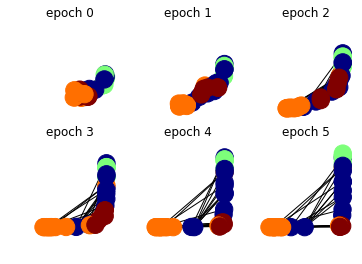

In [79]:
outputs={}
test_outputs={}
for epoch in range(6):
    avg_cost=0
    for i in range(50):
        batch_xs, batch_ys, adj=feat_x.reshape((1,34,34)),  y_train.reshape((1,34,4)), np.array(adj_norm).reshape((1,34,34))
        avg_cost=model.train(batch_xs, batch_ys, train_mask.reshape((1,34)), avg_cost/50, adj)
    preds, train_acc, outputs[epoch]=model.accuracy(batch_xs, batch_ys, train_mask.reshape((1,34)), adj)
    preds, test_acc, _=model.accuracy(batch_xs, y_test.reshape((1,34,4)), test_mask.reshape((1,34)), adj)
    print('Epoch:','%04d' %(epoch+1),'cost=', np.round(avg_cost,5),'train_acc: ',train_acc, '  test_acc: ',test_acc)

model.draw(g,outputs)
    


In [30]:
np.argmax(preds,1)

array([0, 0, 0, 0, 1, 1, 1, 0, 2, 2, 1, 3, 0, 0, 2, 2, 1, 0, 2, 0, 2, 0,
       2, 3, 3, 3, 2, 3, 3, 2, 2, 3, 2, 2], dtype=int64)

In [31]:
targets

array([0, 0, 0, 0, 1, 1, 1, 0, 2, 2, 1, 0, 0, 0, 2, 2, 1, 0, 2, 0, 2, 0,
       2, 3, 3, 3, 2, 3, 3, 2, 2, 3, 2, 2])

# Gated Attention Graph Neural Netoworks

### From Ryu's paper

 Here, we need to take one more fact into account when using the GCN. Performing multiple graph convolutions enables the model to carry over information from distant atoms. Kipf and Welling reported effects of the model depth for GCN.47 Without the skipconnection, they could not train models with more than 7 graph convolution layers. Although using the skip-connection allowed them to achieve deeper models, accuracy of the models was gradually lowered as the number of convolution layers increases. We also observed the similar results (see in Fig. 3(a)). To avoid the aforementioned problems, which is related to the second missing term, we propose a gated skip-connection. The concept of gate is used in recurrent cell units such as the gated recurrentunit(GRU)45 andthelong-shorttermmemory(LSTM)55. When a model updates sequential hidden states, the gate is used to deliver previous information accurately by determining forget and update rates. Inspired from the gate mechanism in the recurrent cell units, we adopt the gate in using the skip-connection. 

In [64]:
class GAGN:
    def __init__(self, layer, n_nodes, f_dimension, nb_classes):
        self.X = tf.placeholder('float32',shape=(None, n_nodes, f_dimension), name='x')
        self.y = tf.placeholder('float32', shape=(None, n_nodes, nb_classes), name='y')
        self.adj=tf.placeholder('float32',shape=(None, n_nodes, n_nodes))
        self.mask=tf.placeholder('float32',shape=(None, n_nodes), name='x')
        self.output_dim = nb_classes
        self.layer = layer
        self.is_train = tf.placeholder(tf.bool)
        self.nodes = n_nodes
        self.dropout=tf.placeholder(tf.float32)

    def loss(self,  lr, optim=tf.train.AdamOptimizer):
        self.L=tf.identity(self.X)
        for i,hidden_layer in enumerate(self.layer):
            self.L = tf.layers.dense(self.L, hidden_layer) 
            attn_coeffs = self.attn_coeffs(self.L, self.adj)
            self.L = tf.matmul(attn_coeffs, self.L) # [batch_size, num_nodes, num_nodes]  
            # Message state
            m = tf.matmul(self.adj, self.L)
            # Update node state using GRU cell
            L_total = []
            cell = tf.contrib.rnn.GRUCell(hidden_layer, activation=tf.tanh, name='GRUcell'+str(i))
            for i in range(self.nodes):
                mi = tf.reshape(m[:,i,:],(-1, 1, hidden_layer))
                hi = self.L[:,i,:]
                _, h = tf.nn.dynamic_rnn(cell, mi, initial_state=hi)
                L_total.append(tf.reshape(h,(-1, 1, hidden_layer)))
            self.L = tf.concat(L_total, 1)
            self.L = tf.nn.dropout(self.L, self.dropout)

        self.hypothesis = tf.layers.dense(tf.matmul(self.adj,self.L), self.output_dim, activation=tf.nn.softmax)
        self.cost=tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.y, logits=self.hypothesis)
        mask = tf.cast(self.mask, dtype=tf.float32)
        mask /= tf.reduce_mean(mask)
                               
        self.cost *= mask       
        self.cost=tf.reduce_mean(self.cost)
        
        self.optimizer = optim(learning_rate=lr)
        self.trains = self.optimizer.minimize(self.cost)
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())        
      
    def attn_coeffs(self, H, A, active=tf.nn.leaky_relu):
        B, N, D= H.get_shape().as_list()
        a_input = tf.reshape(tf.concat([tf.reshape(tf.tile(H,(1,1, N)),(1,N*N,-1)), tf.tile(H,(1,N,1))], axis=1),(-1,N, N, 2 * D))
        e = active(tf.reshape(tf.matmul(tf.reshape(a_input,[-1,D*2]),tf.zeros(shape=(D*2, 1))),[-1,N,N]))
        zero_vec = -9e15*tf.ones_like(e)
        attention = tf.where(A > 0, e, zero_vec)
        attention = tf.nn.softmax(attention, dim=1)
        return attention
    
    def accuracy(self, X, Y, mask, adj):
        """Accuracy with masking."""
        preds, graph_node=self.sess.run([self.hypothesis, self.L], feed_dict={self.X:X, self.y:Y,  self.adj:adj,
                                                                              self.mask:mask, self.dropout:1})
        correct_prediction = tf.equal(tf.argmax(preds, 2), tf.argmax(Y, 2))
        accuracy_all = tf.cast(correct_prediction, tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        mask /= tf.reduce_mean(mask)
        accuracy_all *= mask
        return preds[0], self.sess.run(tf.reduce_mean(accuracy_all)), graph_node[0]
    
        
    
    def train(self, batch_xs, batch_ys, mask, avg_cost, adj):
        _, c = self.sess.run([self.trains, self.cost], feed_dict={self.X: batch_xs, self.y: batch_ys, self.adj:adj,
                                                                  self.mask:mask, self.dropout:0.9})
        avg_cost += np.mean(c)
        return avg_cost
    
    def draw(self, g, outputs):
        node_positions = {o: {n: tuple(outputs[o][j])
                              for j, n in enumerate(nx.nodes(g))}
                          for o in outputs}
        plot_titles = {o: 'epoch {o}'.format(o=o) for o in outputs}

        # Two subplots, unpack the axes array immediately
        f, axes = plt.subplots(nrows=2, ncols=3, sharey=True, sharex=True)

        e = list(node_positions.keys())

        for i, ax in enumerate(axes.flat):
            pos = node_positions[e[i]]
            ax.set_title(plot_titles[e[i]])

            nx.draw(
                g,
                cmap=plt.get_cmap('jet'),
                node_color=np.log(
                    list(nx.get_node_attributes(g, 'membership').values())),
                pos=pos, ax=ax)

In [65]:
tf.reset_default_graph()
model=GAGN([2], 34, 34, 4)

In [66]:
model.loss(1e-2)

Epoch: 0001 cost= 1.26232 train_acc:  0.6666666   test_acc:  0.5
Epoch: 0002 cost= 1.03618 train_acc:  0.91666657   test_acc:  0.7272727
Epoch: 0003 cost= 0.83008 train_acc:  1.0   test_acc:  1.0
Epoch: 0004 cost= 0.8301 train_acc:  1.0   test_acc:  1.0
Epoch: 0005 cost= 0.78563 train_acc:  1.0   test_acc:  0.95454544
Epoch: 0006 cost= 0.78503 train_acc:  1.0   test_acc:  1.0


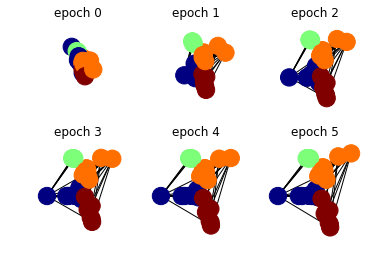

In [67]:
outputs={}
test_outputs={}
for epoch in range(6):
    avg_cost=0
    for i in range(50):
        batch_xs, batch_ys, adj=feat_x.reshape((1,34,34)),  y_train.reshape((1,34,4)), np.array(adj_norm).reshape((1,34,34))
        avg_cost=model.train(batch_xs, batch_ys, train_mask.reshape((1,34)), avg_cost/50, adj)
    preds, train_acc, outputs[epoch]=model.accuracy(batch_xs, batch_ys, train_mask.reshape((1,34)), adj)
    preds, test_acc, _=model.accuracy(batch_xs, y_test.reshape((1,34,4)), test_mask.reshape((1,34)), adj)
    print('Epoch:','%04d' %(epoch+1),'cost=', np.round(avg_cost,5),'train_acc: ',train_acc, '  test_acc: ',test_acc)

model.draw(g,outputs)
    


In [59]:
np.argmax(preds,1)

array([0, 0, 0, 0, 1, 1, 1, 0, 2, 2, 1, 1, 0, 0, 2, 2, 1, 0, 2, 0, 2, 0,
       2, 3, 3, 3, 2, 3, 3, 2, 2, 3, 2, 2], dtype=int64)

In [52]:
targets

array([0, 0, 0, 0, 1, 1, 1, 0, 2, 2, 1, 0, 0, 0, 2, 2, 1, 0, 2, 0, 2, 0,
       2, 3, 3, 3, 2, 3, 3, 2, 2, 3, 2, 2])

# Convert to unsupervised learning(node prediction)

In [15]:
# Semi-supervised
memberships = [m - 1 for m in nx.get_node_attributes(g, 'membership').values()]

nb_classes = len(set(memberships))
targets = np.array([memberships], dtype=np.int32).reshape(-1)
#convert_target_value 
new_targets=[]
for i in targets:
    if i==0:
        v=np.random.randint(100, 1000)
    elif i==1:
        v=np.random.randint(1000, 5000)
    elif i==2:
        v=np.random.randint(10000, 30000)
    elif i==3:
        v=np.random.randint(300, 500)
    new_targets.append(v)
# Pick 3 from each class
labels_to_keep=[17,2,3,0,  4,6,5,10,   8,15,9,20,32,  27,24,25,31]
new_targets=np.array(new_targets)
y_train = np.zeros(shape=(n_nodes,1),
                   dtype=np.float32)

train_mask = np.zeros(shape=(n_nodes,1), dtype=np.bool)

for l in labels_to_keep:
    y_train[l] = new_targets[l]
    train_mask[l] = True

In [16]:
feat_x = np.eye(4)[targets]

## without class info

In [40]:
class GraphConvNet:
    def __init__(self, layer, n_nodes, f_dimension, nb_classes):
        self.X = tf.placeholder('float32',shape=(n_nodes, f_dimension))
        self.y = tf.placeholder('float32', shape=(n_nodes, nb_classes))
        self.mask=tf.placeholder('float32')
        self.output_dim = nb_classes
        self.layer = layer
        self.is_train=tf.placeholder(tf.bool)
    def loss(self, adj_norm, lr,  use_dropout=0.9, optim=tf.train.AdamOptimizer):
        self.L=tf.identity(self.X)
        for j in range(len(self.layer)):
            self.L=tf.contrib.layers.fully_connected(tf.matmul(adj_norm,self.L), num_outputs=self.layer[j],
                                             activation_fn=tf.nn.relu, weights_initializer=tf.contrib.layers.xavier_initializer())
            self.L= tf.contrib.layers.dropout(self.L, keep_prob=use_dropout, is_training=self.is_train)
        self.hypothesis=tf.contrib.layers.fully_connected(tf.matmul(adj_norm,self.L), num_outputs=256,
                                             activation_fn=tf.nn.relu)            
        self.hypothesis=tf.layers.dense(tf.matmul(adj_norm, self.hypothesis), 32, activation=tf.nn.relu)
        self.hypothesis=tf.layers.dense(tf.matmul(adj_norm, self.hypothesis), 1, activation=None)
        
        self.hypothesis=tf.pow(self.hypothesis,2)
        self.hypothesis=tf.sqrt(self.hypothesis)
    
        self.cost=tf.square(self.y- self.hypothesis)
        mask = tf.cast(self.mask, dtype=tf.float32)
        self.cost_masked =self.cost*mask       
        self.cost=tf.reduce_mean(self.cost_masked)
        
        self.optimizer = optim(learning_rate=lr)
        self.trains = self.optimizer.minimize(self.cost)
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    

    def prediction(self, X):
        preds=self.sess.run(self.hypothesis, feed_dict={self.X:X, self.is_train:False})
        preds=self.sess.run(tf.cast(preds, tf.int32))
        return preds
    
        
    
    def train(self, batch_xs, batch_ys, mask, avg_cost):
        _, c, m = self.sess.run([self.trains, self.cost, self.cost_masked], feed_dict={self.X: batch_xs, self.y: batch_ys, self.mask:mask, self.is_train:True})
        avg_cost += np.mean(c)
        return avg_cost, m
    
    def draw(self, g, outputs):
        node_positions = {o: {n: tuple(outputs[o][j])
                              for j, n in enumerate(nx.nodes(g))}
                          for o in outputs}
        plot_titles = {o: 'epoch {o}'.format(o=o) for o in outputs}

        # Two subplots, unpack the axes array immediately
        f, axes = plt.subplots(nrows=2, ncols=3, sharey=True, sharex=True)

        e = list(node_positions.keys())

        for i, ax in enumerate(axes.flat):
            pos = node_positions[e[i]]
            ax.set_title(plot_titles[e[i]])

            nx.draw(
                g,
                cmap=plt.get_cmap('jet'),
                node_color=np.log(
                    list(nx.get_node_attributes(g, 'membership').values())),
                pos=pos, ax=ax)

In [41]:
tf.reset_default_graph()
model=GraphConvNet([64, 64, 64, 64, 64], 34, 4, 1)

In [42]:
model.loss(adj_norm, 1e-2)

In [43]:
for epoch in range(10):
    avg_cost=0
    for i in range(1000):
        batch_xs, batch_ys=feat_x,  y_train
        avg_cost, masked=model.train(batch_xs, batch_ys, train_mask, avg_cost/1000)
    print('Epoch:','%04d' %(epoch+1),'cost=', np.round(avg_cost,2))

Epoch: 0001 cost= 15789894.69
Epoch: 0002 cost= 10767054.79
Epoch: 0003 cost= 8775984.32
Epoch: 0004 cost= 5834934.2
Epoch: 0005 cost= 1716624.16
Epoch: 0006 cost= 2916196.29
Epoch: 0007 cost= 487658.87
Epoch: 0008 cost= 538625.63
Epoch: 0009 cost= 11607045.68
Epoch: 0010 cost= 7504702.85


In [44]:
model.prediction(feat_x)

array([[   23],
       [ 5955],
       [ 7811],
       [   23],
       [   23],
       [   23],
       [   23],
       [   23],
       [14379],
       [16342],
       [   23],
       [   23],
       [   23],
       [ 3869],
       [12993],
       [12993],
       [   23],
       [   23],
       [12993],
       [ 4734],
       [12993],
       [   23],
       [12993],
       [10837],
       [   23],
       [   23],
       [13830],
       [ 4237],
       [ 4734],
       [13842],
       [15750],
       [ 6224],
       [20974],
       [23309]])

## class info included

In [31]:
class GraphConvNet:
    def __init__(self, layer, n_nodes, f_dimension, nb_classes):
        self.X = tf.placeholder('float32',shape=(n_nodes, f_dimension))
        self.y = tf.placeholder('float32', shape=(n_nodes, 1))
        self.mask=tf.placeholder('float32')
        self.output_dim = nb_classes
        self.layer = layer
        self.is_train=tf.placeholder(tf.bool)
        self.condition=tf.placeholder(tf.int32, shape=[n_nodes, nb_classes], name="condition")
        self.n_nodes=n_nodes
  
    def loss(self, adj_norm, lr,  use_dropout=0.9, optim=tf.train.AdamOptimizer):
        self.L=tf.identity(self.X)
        for j in range(len(self.layer)):
            self.L=tf.contrib.layers.fully_connected(tf.matmul(adj_norm,self.L), num_outputs=self.layer[j],
                                             activation_fn=tf.nn.relu, weights_initializer=tf.contrib.layers.xavier_initializer())
            self.L= tf.contrib.layers.dropout(self.L, keep_prob=use_dropout, is_training=self.is_train)
        self.hypothesis=tf.contrib.layers.fully_connected(tf.matmul(adj_norm,self.L), num_outputs=256,
                                             activation_fn=tf.nn.relu, weights_initializer=tf.contrib.layers.xavier_initializer())            

        
        
        
        classify={}
        for i in range(self.output_dim):
            classify[i]=tf.layers.dense(tf.matmul(adj_norm,self.hypothesis), 32, activation=tf.nn.relu)
        
        
        # for문이 많지만 결국 한 개 층임 (classify(j)를 적용해주는 레이어임)
        ydict={}
        for i in range(self.n_nodes):
            for j in range(self.output_dim):
                ydict['y'+str(i)] = tf.cond(self.condition[i][j] > 0, true_fn=lambda: tf.layers.dense(tf.matmul(adj_norm, classify[j]), 1, activation=None), 
                    false_fn = lambda: tf.identity(ydict.get('y'+str(i), tf.matmul(adj_norm, classify[j]))))   
               
        
        self.concat=tf.concat([tf.reshape(tf.reduce_sum(ydict['y'+str(0)]),(1,1)), tf.reshape(tf.reduce_sum(ydict['y'+str(1)]),(1,1))], 0)
        
        for i in range(2, self.n_nodes):
            self.concat=tf.concat([self.concat, tf.reshape(tf.reduce_sum(ydict['y'+str(i)]),(1,1))], 0)
        self.concat=tf.pow(self.concat,2)
        self.concat=tf.sqrt(self.concat)
            
    
        self.cost=tf.square(self.y- self.concat)
        mask = tf.cast(self.mask, dtype=tf.float32)
        self.cost_masked =self.cost*mask       
        self.cost=tf.reduce_mean(self.cost_masked)
        
        self.optimizer = optim(learning_rate=lr)
        self.trains = self.optimizer.minimize(self.cost)
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    

    def prediction(self, X):
        preds=self.sess.run(self.concat, feed_dict={self.X:X, self.condition:self.cond, self.is_train:False})
        preds=self.sess.run(tf.cast(preds, tf.int32))
        return preds
    
        
    
    def train(self, batch_xs, batch_ys, mask, avg_cost, cond):
        self.cond=cond
        _, c, m = self.sess.run([self.trains, self.cost, self.cost_masked], feed_dict={self.X: batch_xs, self.y: batch_ys, self.condition:cond
                                                                                       ,self.mask:mask, self.is_train:True})
        avg_cost += np.mean(c)
        return avg_cost, m
    
    def draw(self, g, outputs):
        node_positions = {o: {n: tuple(outputs[o][j])
                              for j, n in enumerate(nx.nodes(g))}
                          for o in outputs}
        plot_titles = {o: 'epoch {o}'.format(o=o) for o in outputs}

        # Two subplots, unpack the axes array immediately
        f, axes = plt.subplots(nrows=2, ncols=3, sharey=True, sharex=True)

        e = list(node_positions.keys())

        for i, ax in enumerate(axes.flat):
            pos = node_positions[e[i]]
            ax.set_title(plot_titles[e[i]])

            nx.draw(
                g,
                cmap=plt.get_cmap('jet'),
                node_color=np.log(
                    list(nx.get_node_attributes(g, 'membership').values())),
                pos=pos, ax=ax)

In [32]:
tf.reset_default_graph()
model=GraphConvNet([32, 32, 32, 32], 34, 4, 4)

In [33]:
model.loss(adj_norm, 1e-3)

In [34]:
for epoch in range(5):
    avg_cost=0
    for i in range(1000):
        batch_xs, batch_ys=feat_x,  y_train
        avg_cost, masked=model.train(batch_xs, batch_ys, train_mask, avg_cost/1000, feat_x)
    print('Epoch:','%04d' %(epoch+1),'cost=', np.round(avg_cost,2))

Epoch: 0001 cost= 287193.69
Epoch: 0002 cost= 11726.68
Epoch: 0003 cost= 2647.5
Epoch: 0004 cost= 5112.94
Epoch: 0005 cost= 24611.08


In [35]:
model.prediction(feat_x)

array([[  519],
       [  463],
       [  341],
       [  230],
       [ 2759],
       [ 3020],
       [ 1786],
       [   20],
       [17833],
       [25568],
       [ 1620],
       [  207],
       [  622],
       [   53],
       [ 5368],
       [15798],
       [ 1281],
       [  740],
       [  528],
       [  455],
       [14423],
       [  140],
       [13025],
       [  158],
       [  389],
       [  433],
       [ 1188],
       [  299],
       [   94],
       [ 3018],
       [  418],
       [  313],
       [22488],
       [ 4866]])

In [36]:
new_targets

array([  531,   426,   337,   241,  2940,  3197,  1895,   877, 18606,
       26630,  1703,   622,   276,   231, 19695, 16469,  3946,   818,
       22073,   449, 15042,   280, 10627,   463,   403,   422, 26291,
         337,   338, 16556, 16152,   337, 23441, 22298])

# Cora Datasets

In [29]:
def parse_index_file(filename):
    """Parse index file."""
    index = []
    for line in open(filename):
        index.append(int(line.strip()))
    return index


def sample_mask(idx, l):
    """Create mask."""
    mask = np.zeros(l)
    mask[idx] = 1
    return np.array(mask, dtype=np.bool)


def load_data(dataset_str):
    """
    Loads input data from gcn/data directory

    ind.dataset_str.x => the feature vectors of the training instances as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.tx => the feature vectors of the test instances as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.allx => the feature vectors of both labeled and unlabeled training instances
        (a superset of ind.dataset_str.x) as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.y => the one-hot labels of the labeled training instances as numpy.ndarray object;
    ind.dataset_str.ty => the one-hot labels of the test instances as numpy.ndarray object;
    ind.dataset_str.ally => the labels for instances in ind.dataset_str.allx as numpy.ndarray object;
    ind.dataset_str.graph => a dict in the format {index: [index_of_neighbor_nodes]} as collections.defaultdict
        object;
    ind.dataset_str.test.index => the indices of test instances in graph, for the inductive setting as list object.

    All objects above must be saved using python pickle module.

    :param dataset_str: Dataset name
    :return: All data input files loaded (as well the training/test data).
    """
    names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'graph']
    objects = []
    for i in range(len(names)):
        with open("D:/bigdata/Python/Graph Neural Net/Graph-neural-networks-master/tutorials/data/ind.{}.{}".format(dataset_str, names[i]), 'rb') as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding='latin1'))
            else:
                objects.append(pkl.load(f))

    x, y, tx, ty, allx, ally, graph = tuple(objects)
    test_idx_reorder = parse_index_file("D:/bigdata/Python/Graph Neural Net/Graph-neural-networks-master/tutorials/data/ind.{}.test.index".format(dataset_str))
    test_idx_range = np.sort(test_idx_reorder)
    
    if dataset_str == 'citeseer':
        # Fix citeseer dataset (there are some isolated nodes in the graph)
        # Find isolated nodes, add them as zero-vecs into the right position
        test_idx_range_full = range(min(test_idx_reorder), max(test_idx_reorder)+1)
        tx_extended = sp.lil_matrix((len(test_idx_range_full), x.shape[1]))
        tx_extended[test_idx_range-min(test_idx_range), :] = tx
        tx = tx_extended
        ty_extended = np.zeros((len(test_idx_range_full), y.shape[1]))
        ty_extended[test_idx_range-min(test_idx_range), :] = ty
        ty = ty_extended

    features = sp.vstack((allx, tx)).tolil()
    features[test_idx_reorder, :] = features[test_idx_range, :]
    
    adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))

    labels = np.vstack((ally, ty))
    labels[test_idx_reorder, :] = labels[test_idx_range, :]

    idx_test = test_idx_range.tolist()
    idx_train = range(len(y))
    idx_val = range(len(y), len(y)+500)

    train_mask = sample_mask(idx_train, labels.shape[0])
    val_mask = sample_mask(idx_val, labels.shape[0])
    test_mask = sample_mask(idx_test, labels.shape[0])

    y_train = np.zeros(labels.shape)
    y_val = np.zeros(labels.shape)
    y_test = np.zeros(labels.shape)
    y_train[train_mask, :] = labels[train_mask, :]
    y_val[val_mask, :] = labels[val_mask, :]
    y_test[test_mask, :] = labels[test_mask, :]

    return adj, features, np.array(y_train), np.array(y_val), np.array(y_test), np.array(train_mask), np.array(val_mask), np.array(test_mask), graph


def sparse_to_tuple(sparse_mx):
    """Convert sparse matrix to tuple representation."""
    def to_tuple(mx):
        if not sp.isspmatrix_coo(mx):
            mx = mx.tocoo()
        coords = np.vstack((mx.row, mx.col)).transpose()
        values = mx.data
        shape = mx.shape
        return coords, values, shape

    if isinstance(sparse_mx, list):
        for i in range(len(sparse_mx)):
            sparse_mx[i] = to_tuple(sparse_mx[i])
    else:
        sparse_mx = to_tuple(sparse_mx)

    return sparse_mx


def preprocess_features(features):
    """Row-normalize feature matrix and convert to tuple representation"""
    rowsum = np.array(features.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    features = r_mat_inv.dot(features)
    return sparse_to_tuple(features)


def normalize_adj(adj):
    """Symmetrically normalize adjacency matrix."""
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()


def preprocess_adj(adj):
    """Preprocessing of adjacency matrix for simple GCN model and conversion to tuple representation."""
    adj_normalized = normalize_adj(adj + sp.eye(adj.shape[0]))
    return sparse_to_tuple(adj_normalized)


def construct_feed_dict(features, support, labels, labels_mask, placeholders):
    """Construct feed dictionary."""
    feed_dict = dict()
    feed_dict.update({placeholders['labels']: labels})
    feed_dict.update({placeholders['labels_mask']: labels_mask})
    feed_dict.update({placeholders['features']: features})
    feed_dict.update({placeholders['support'][i]: support[i] for i in range(len(support))})
    feed_dict.update({placeholders['num_features_nonzero']: features[1].shape})
    return feed_dict


def chebyshev_polynomials(adj, k):
    """Calculate Chebyshev polynomials up to order k. Return a list of sparse matrices (tuple representation)."""
    print("Calculating Chebyshev polynomials up to order {}...".format(k))

    adj_normalized = normalize_adj(adj)
    laplacian = sp.eye(adj.shape[0]) - adj_normalized
    largest_eigval, _ = eigsh(laplacian, 1, which='LM')
    scaled_laplacian = (2. / largest_eigval[0]) * laplacian - sp.eye(adj.shape[0])

    t_k = list()
    t_k.append(sp.eye(adj.shape[0]))
    t_k.append(scaled_laplacian)

    def chebyshev_recurrence(t_k_minus_one, t_k_minus_two, scaled_lap):
        s_lap = sp.csr_matrix(scaled_lap, copy=True)
        return 2 * s_lap.dot(t_k_minus_one) - t_k_minus_two

    for i in range(2, k+1):
        t_k.append(chebyshev_recurrence(t_k[-1], t_k[-2], scaled_laplacian))

    return sparse_to_tuple(t_k)


In [30]:
adj_cora, features_cora, y_train_cora, y_val_cora, y_test_cora, train_mask_cora, val_mask_cora, test_mask_cora, cora_graph = load_data('cora')

In [31]:
features_cora=np.array(features_cora.todense())

In [32]:
adj_norm_cora = normalize_adj(adj_cora + sp.eye(adj_cora.shape[0]))
adj_norm_cora=adj_norm_cora.todense()
adj_norm_cora=np.array(adj_norm_cora.astype(np.float32))

In [33]:
print('feature shape: ',features_cora.shape)
print('adj_norm_cora shape: ',adj_norm_cora.shape)
print('y_train_cora shape: ',y_train_cora.shape)

feature shape:  (2708, 1433)
adj_norm_cora shape:  (2708, 2708)
y_train_cora shape:  (2708, 7)


# GCN

In [34]:
tf.reset_default_graph()
model_cora=GCN([64], 2708, 1433, 7)
model_cora.loss(1e-2)

In [35]:
outputs={}
test_outputs={}
for epoch in range(6):
    avg_cost=0
    for i in range(50):
        batch_xs, batch_ys, adj=features_cora,  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/30, adj)
    train_acc, outputs[epoch]=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    val_acc, _=model_cora.accuracy(batch_xs, y_val_cora, val_mask_cora, adj)
    test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
    print('Epoch:','%04d' %(epoch+1),'cost=', np.round(avg_cost,2),'train_acc: ',train_acc,  ' val_acc: ' ,val_acc, ' test_acc: ',test_acc)

Epoch: 0001 cost= 1.21 train_acc:  1.0000002  val_acc:  0.76199996  test_acc:  0.76499903
Epoch: 0002 cost= 1.21 train_acc:  1.0000002  val_acc:  0.76199996  test_acc:  0.771999
Epoch: 0003 cost= 1.21 train_acc:  1.0000002  val_acc:  0.76399994  test_acc:  0.775999
Epoch: 0004 cost= 1.21 train_acc:  1.0000002  val_acc:  0.766  test_acc:  0.77499896
Epoch: 0005 cost= 1.21 train_acc:  1.0000002  val_acc:  0.76199996  test_acc:  0.776999
Epoch: 0006 cost= 1.21 train_acc:  1.0000002  val_acc:  0.76199996  test_acc:  0.77499896


# GAT

In [36]:
tf.reset_default_graph()
model_cora=GAT_original([16], 2708, 1433, 7)
model_cora.loss(1e-2)

In [37]:
outputs={}
for epoch in range(6):
    avg_cost=0
    for i in range(50):
        batch_xs, batch_ys, adj=features_cora.reshape((1,2708,1433)),  y_train_cora.reshape((1,2708,7)), adj_norm_cora.reshape((1,2708,2708))
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora.reshape((1,2708)), avg_cost/30, adj)
    preds, train_acc, outputs[epoch]=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora.reshape((1,2708)), adj)
    preds, val_acc, _=model_cora.accuracy(batch_xs, y_val_cora.reshape((1,2708,7)), val_mask_cora.reshape((1,2708)), adj)
    preds, test_acc, _=model_cora.accuracy(batch_xs, y_test_cora.reshape((1,2708,7)), test_mask_cora.reshape((1,2708)), adj)
    print('Epoch:','%04d' %(epoch+1),'cost=', np.round(avg_cost,2),'train_acc: ',train_acc,  ' val_acc: ' ,val_acc, ' test_acc: ',test_acc)

Epoch: 0001 cost= 1.21 train_acc:  1.0000002  val_acc:  0.7759999  test_acc:  0.7989991
Epoch: 0002 cost= 1.21 train_acc:  1.0000002  val_acc:  0.76999986  test_acc:  0.79699904
Epoch: 0003 cost= 1.21 train_acc:  1.0000002  val_acc:  0.7679999  test_acc:  0.7979991
Epoch: 0004 cost= 1.21 train_acc:  1.0000002  val_acc:  0.76999986  test_acc:  0.79699904
Epoch: 0005 cost= 1.21 train_acc:  1.0000002  val_acc:  0.76999986  test_acc:  0.792999
Epoch: 0006 cost= 1.21 train_acc:  1.0000002  val_acc:  0.76999986  test_acc:  0.793999


# GGNN

In [26]:
tf.reset_default_graph()
model_cora=GGNN([16], 2708, 1433, 7)
model_cora.loss(1e-2)

NameError: name 'GGNN' is not defined

In [27]:
outputs={}
for epoch in range(6):
    avg_cost=0
    for i in range(50):
        batch_xs, batch_ys, adj=features_cora.reshape((1,2708,1433)),  y_train_cora.reshape((1,2708,7)), adj_norm_cora.reshape((1,2708,2708))
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora.reshape((1,2708)), avg_cost/30, adj)
    preds, train_acc, outputs[epoch]=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora.reshape((1,2708)), adj)
    preds, val_acc, _=model_cora.accuracy(batch_xs, y_val_cora.reshape((1,2708,7)), val_mask_cora.reshape((1,2708)), adj)
    preds, test_acc, _=model_cora.accuracy(batch_xs, y_test_cora.reshape((1,2708,7)), test_mask_cora.reshape((1,2708)), adj)
    print('Epoch:','%04d' %(epoch+1),'cost=', np.round(avg_cost,2),'train_acc: ',train_acc,  ' val_acc: ' ,val_acc, ' test_acc: ',test_acc)

ValueError: Cannot feed value of shape (1, 2708, 1433) for Tensor 'Placeholder:0', which has shape '(2708, 1433)'